In [12]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2, id2label={0: 'No', 1: 'Yes'}, label2id={'No': 0, 'Yes': 1})
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# load datasets 

in_dist_dataset = torch.load('dump/bert_in_dist_dataset.pt')
adv_dataset = torch.load('dump/bert_adv_dataset.pt')

In [14]:
# elem[0] in dataset is currently tokenized with a different tokenizer
# want to decode with bert_tokenizer and then encode with tokenizer
# want to do this using a torch dataset native operation

decoded = bert_tokenizer.batch_decode(in_dist_dataset.tensors[0], skip_special_tokens=True)
encoded = tokenizer(decoded, add_special_tokens=True, truncation=True, padding=True, max_length=128, return_tensors='pt')['input_ids']

in_dist_dataset = torch.utils.data.TensorDataset(encoded, in_dist_dataset.tensors[1], in_dist_dataset.tensors[2])

decoded = bert_tokenizer.batch_decode(adv_dataset.tensors[0], skip_special_tokens=True)
encoded = tokenizer(decoded, add_special_tokens=True, truncation=True, padding=True, max_length=128, return_tensors='pt')['input_ids']

adv_dataset = torch.utils.data.TensorDataset(encoded, adv_dataset.tensors[1], adv_dataset.tensors[2])

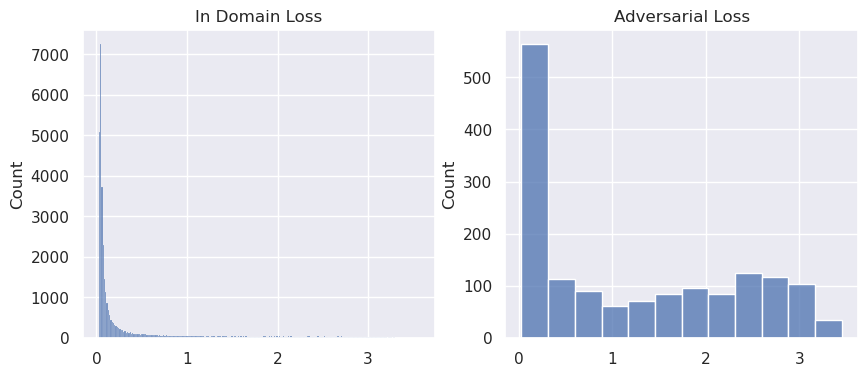

In [15]:
bert_in_dist_loss = in_dist_dataset.tensors[2].numpy()
bert_adv_loss = adv_dataset.tensors[2].numpy()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(bert_in_dist_loss, ax=axs[0])
sns.histplot(bert_adv_loss, ax=axs[1])
axs[0].set_title('In Domain Loss')
axs[1].set_title('Adversarial Loss')
plt.show()

In [16]:
in_dist_true = in_dist_dataset.tensors[1] == 1
in_dist_true = in_dist_dataset[in_dist_true]
in_dist_false = in_dist_dataset.tensors[1] == 0
in_dist_false = in_dist_dataset[in_dist_false]

in_dist_true = torch.utils.data.TensorDataset(in_dist_true[0], in_dist_true[1], in_dist_true[2])
in_dist_false = torch.utils.data.TensorDataset(in_dist_false[0], in_dist_false[1], in_dist_false[2])

in_dist_train_size = int(len(in_dist_true)*0.98)

in_dist_train_true, in_dist_val_true = torch.utils.data.random_split(in_dist_true, [in_dist_train_size, len(in_dist_true) - in_dist_train_size])
in_dist_train_false, in_dist_val_false = torch.utils.data.random_split(in_dist_false, [in_dist_train_size, len(in_dist_false) - in_dist_train_size])

in_dist_train = torch.utils.data.ConcatDataset([in_dist_train_true, in_dist_train_false])
in_dist_val = torch.utils.data.ConcatDataset([in_dist_val_true, in_dist_val_false])

adv_true = adv_dataset.tensors[1] == 1
adv_true = adv_dataset[adv_true]
adv_false = adv_dataset.tensors[1] == 0
adv_false = adv_dataset[adv_false]

adv_true = torch.utils.data.TensorDataset(adv_true[0], adv_true[1], adv_true[2])
adv_false = torch.utils.data.TensorDataset(adv_false[0], adv_false[1], adv_false[2])

val_train_size = int(len(adv_true)*0.8)

adv_train_true, adv_val_true = torch.utils.data.random_split(adv_true, [val_train_size, len(adv_true) - val_train_size])
adv_train_false, adv_val_false = torch.utils.data.random_split(adv_false, [val_train_size, len(adv_false) - val_train_size])

adv_val = torch.utils.data.ConcatDataset([adv_val_true, adv_val_false])
adv_train = torch.utils.data.ConcatDataset([adv_train_true, adv_train_false])

In [17]:
# training loop
# train on in_dist_train_dataset
# eval on in_dist_val_dataset_true, in_dist_val_dataset_false, adv_val_dataset_true, adv_val_dataset_false

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

def train(model, optimizer, criterion, train_dataset, train_batch_size, eval_datasets, eval_batch_size, device, num_epochs=1): 
    model.train()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    batchwise_loss = []
    eval_losses = []

    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            # outputs = model(input_ids=input_ids, labels=input_ids)
            # logits = outputs.logits
            # loss = outputs.loss

            # logits = logits[:, :-1, :].contiguous()
            # input_ids = input_ids[:, 1:].contiguous()
            # input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

            # loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).mean(-1)
            # # labels = batch[1].to(device)
            # # loss = torch.where(labels == 1, loss, 0.1 * -loss)
            # loss = loss.mean()

            # # assert torch.allclose(loss, outputs.loss.mean(), rtol=1e-1), f'{loss} != {outputs.loss.mean()}'
            
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()

            # num_na = 0
            # for p in model.parameters(): 
            #     num_na += torch.sum(torch.isnan(p)).item()
            # print(num_na)

            batchwise_loss.append(accuracy)
            eval_stats = []
            for eval_dataset in eval_datasets:
                eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr = eval_model(model, criterion, eval_dataset, eval_batch_size, device)
                eval_stats.append((eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr))
            eval_losses.append(eval_stats)
            
            # if i % 5 == 0: 
            #     in_dist_true_loss = [elem[0] for elem in eval_losses]
            #     in_dist_false_loss = [elem[1] for elem in eval_losses]
            #     adv_true_loss = [elem[2] for elem in eval_losses]
            #     adv_false_loss = [elem[3] for elem in eval_losses]

            #     sns.set()
            #     sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
            #     sns.lineplot(x=range(len(in_dist_true_loss)), y=in_dist_true_loss, label='in_dist_true')
            #     sns.lineplot(x=range(len(in_dist_false_loss)), y=in_dist_false_loss, label='in_dist_false')
            #     sns.lineplot(x=range(len(adv_true_loss)), y=adv_true_loss, label='adv_true')
            #     sns.lineplot(x=range(len(adv_false_loss)), y=adv_false_loss, label='adv_false')
            #     plt.legend()
            #     plt.show()

            if i % 5 == 0: 
                in_dist_val_acc, in_dist_val_tpr, in_dist_val_fpr, in_dist_val_tnr, in_dist_val_fnr = eval_model(model, criterion, eval_datasets[0], eval_batch_size, device)
                adv_val_acc, adv_val_tpr, adv_val_fpr, adv_val_tnr, adv_val_fnr = eval_model(model, criterion, eval_datasets[1], eval_batch_size, device)
                
                sns.set()
                sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[0][0] for elem in eval_losses], label='in_dist_val_acc')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[1][0] for elem in eval_losses], label='adv_val_acc')

                plt.legend()

                plt.show()

        torch.cuda.empty_cache()

    return batchwise_loss, eval_losses
    
def eval_model(model, criterion, eval_dataset, eval_batch_size, device):
    model.eval()
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=True)
    accuracies = []
    tpr, fpr, tnr, fnr = [], [], [], []
    with torch.no_grad(): 
        for batch in eval_loader: 
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()
            accuracies.append(accuracy)
            tpr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 1)).float().mean().item())
            fpr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 0)).float().mean().item())
            tnr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 0)).float().mean().item())
            fnr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 1)).float().mean().item())
    return np.mean(accuracies), np.mean(tpr), np.mean(fpr), np.mean(tnr), np.mean(fnr)

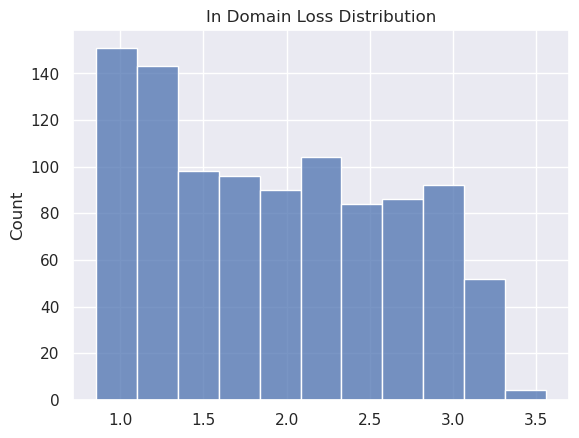

In [21]:
bootstrap_high_size = 5000
high_frac = 1
final_train_size = 1000

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

In [22]:
len(to_train), len(in_dist_val), len(adv_train), len(adv_val)

(1000, 686, 1232, 308)

  0%|          | 0/16 [00:00<?, ?it/s]

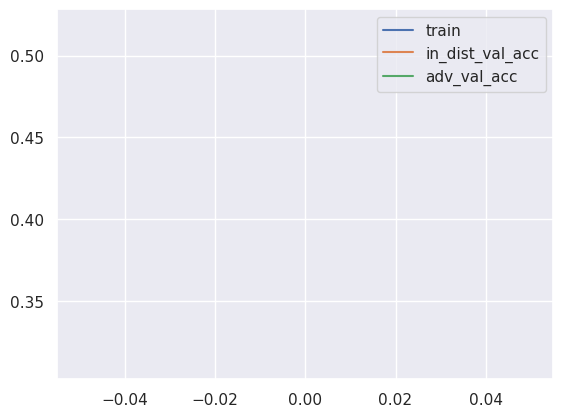

 31%|███▏      | 5/16 [00:47<01:36,  8.74s/it]

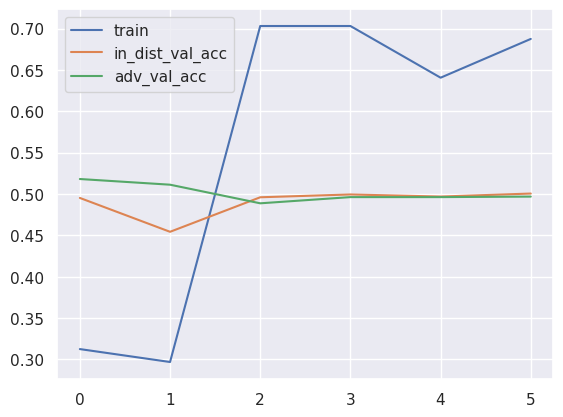

 62%|██████▎   | 10/16 [01:36<00:53,  8.95s/it]

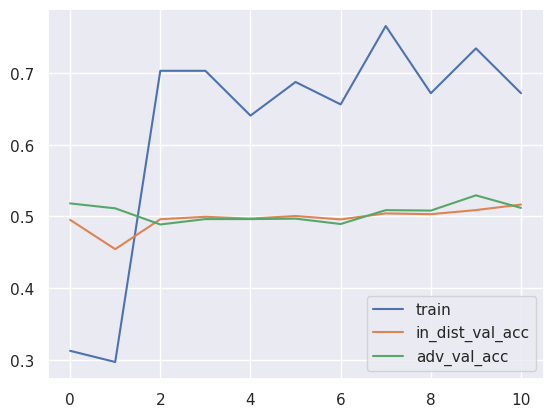

 94%|█████████▍| 15/16 [02:26<00:09,  9.06s/it]

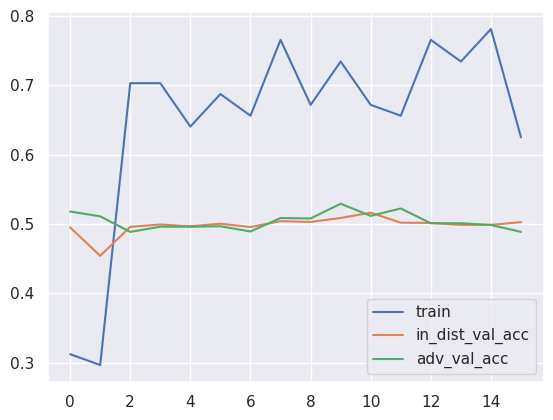

  0%|          | 0/16 [00:00<?, ?it/s]

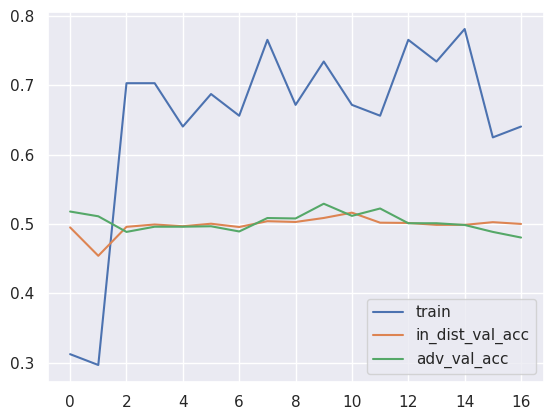

 31%|███▏      | 5/16 [00:50<01:40,  9.14s/it]

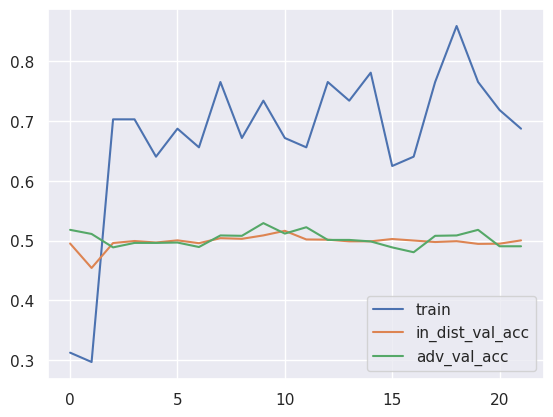

 62%|██████▎   | 10/16 [01:40<00:54,  9.16s/it]

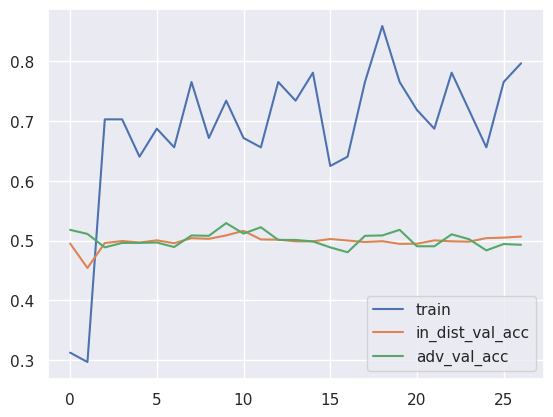

 94%|█████████▍| 15/16 [02:30<00:09,  9.19s/it]

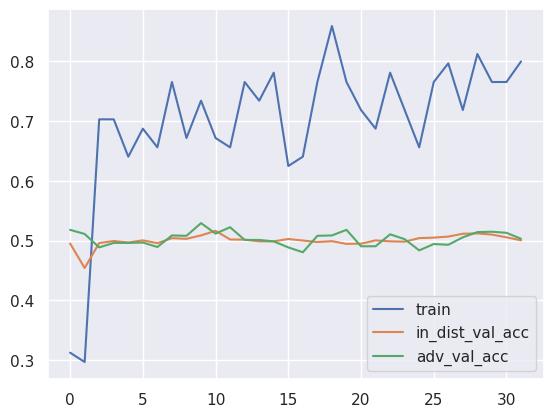

100%|██████████| 16/16 [02:47<00:00, 10.45s/it]


In [23]:
train_batch_size = 64
eval_batch_size = 64
device = 0
model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, to_train, train_batch_size, [in_dist_val, adv_dataset], eval_batch_size, device, num_epochs=2)

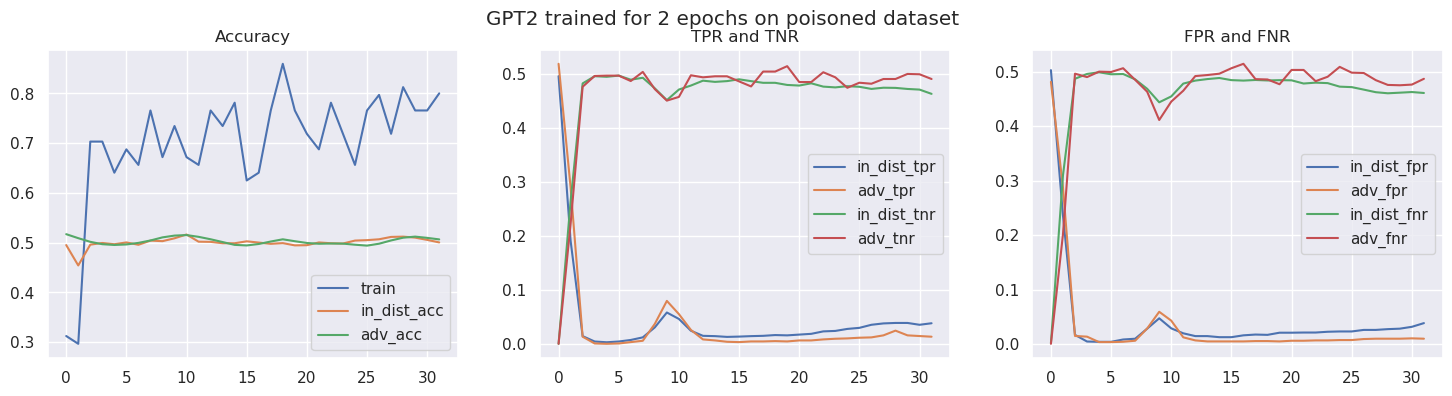

In [29]:
eval_losses = np.array(eval_losses)

in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses[:, 0, 0], eval_losses[:, 0, 1], eval_losses[:, 0, 2], eval_losses[:, 0, 3], eval_losses[:, 0, 4]
adv_acc, adv_tpr, adv_fpr, adv_tnr, adv_fnr = eval_losses[:, 1, 0], eval_losses[:, 1, 1], eval_losses[:, 1, 2], eval_losses[:, 1, 3], eval_losses[:, 1, 4]

# create 3 x 1 plots

import statsmodels.api as sm

fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()

lowess = sm.nonparametric.lowess(train_loss, range(len(train_loss)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0], label='train')
lowess = sm.nonparametric.lowess(in_dist_acc, range(len(in_dist_acc)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0], label='in_dist_acc')
lowess = sm.nonparametric.lowess(adv_acc, range(len(adv_acc)), frac=.2)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0], label='adv_acc')

axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(adv_tpr)), y=adv_tpr, label='adv_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
sns.lineplot(x=range(len(adv_fpr)), y=adv_tnr, label='adv_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(adv_tnr)), y=adv_fpr, label='adv_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
sns.lineplot(x=range(len(adv_fnr)), y=adv_fnr, label='adv_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('GPT2 trained for 2 epochs on poisoned dataset')
plt.show()